# Image colorization network

In this lab we will train an image colorization network. Image generation/translation is more memory and computation consuming task than image classification and is also harder to train. That is why, while is it still possible to run the training for the current assignment on CPU, we recommend to use GPU (if available) or Google Colab.
In the latter case, you will find comments with additional commands to run.

Below is an example of the [Deoldify](https://deoldify.ai) colorization model output on Dmytro Mishkin child B&W photo:

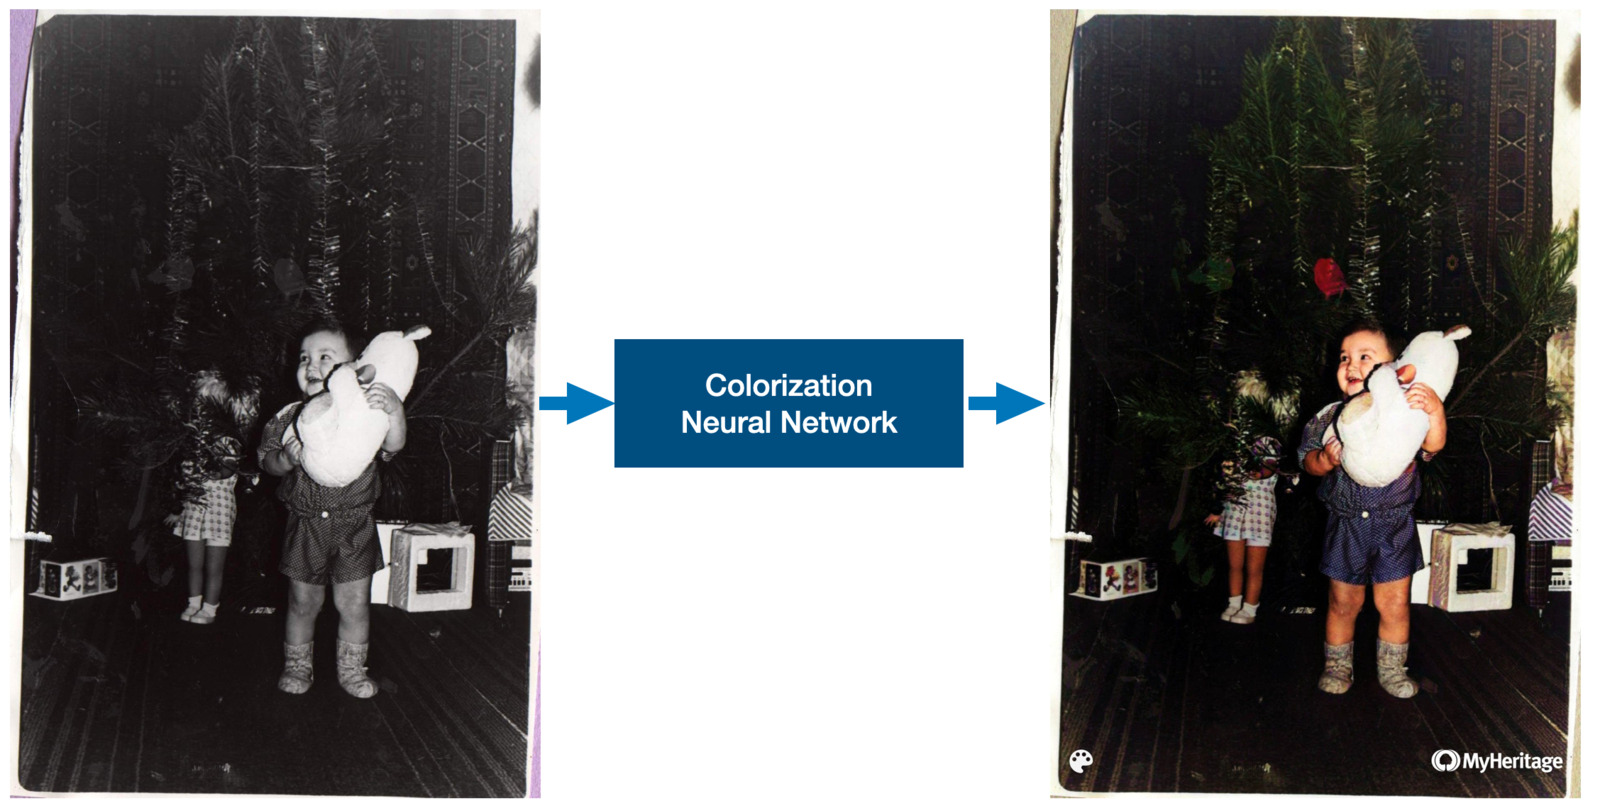


## Overview
We will train a Unet-style CNN with the content (aka [perceptual](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)) loss on the ImageNette dataset, which we have already used in the previous assignment. Now we will go over the functions, classes, models you need to implement and train.

In [2]:
%%capture
!pip install kornia timm

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
import torchvision.transforms as tfms
from tqdm import tqdm_notebook as twdm
from time import time
from fastai.vision.all import *
from fastai.data.all import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loader

We don't need labels, but need two version of the image to train: decolorized as an input and original as target.

It can be simply implemended as following, slightly modifying our previous code for image classification.


In [7]:
#!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
#!tar -xzf imagenette2-160.tgz

--2022-07-25 09:34:51--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.95.128
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.95.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  13.0MB/s    in 8.8s    

2022-07-25 09:35:01 (10.7 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [4]:
from kornia.color import rgb_to_grayscale

def label_func_color(x):
    return x

class RGB2GreyTransform(ItemTransform):
    order = 15 # run after IntToFloatTransform
    def encodes(self, o):
        # expand restores tensor shape back to use c channels 
        # (ie. N,c,h,w) instead of N,1,h,w
        img, mask = o
        return rgb_to_grayscale(img[None].float())[0].expand(3,-1,-1), mask
    

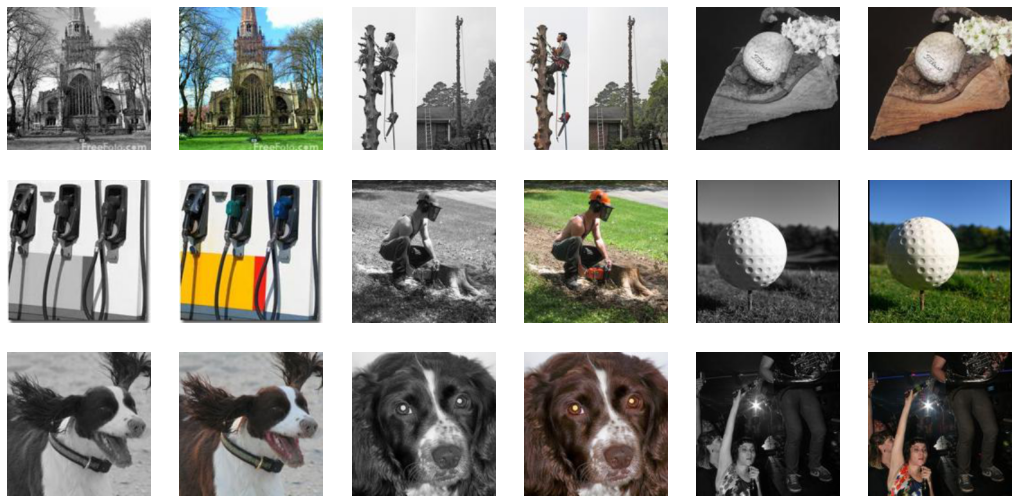

In [9]:
dblock = DataBlock(blocks    = (ImageBlock, ImageBlock),
                   get_items = get_image_files,
                   get_y     = label_func_color,
                   splitter  = RandomSplitter(),
                   item_tfms = [Resize(224), RGB2GreyTransform()])

dsets = dblock.datasets('imagenette2-160/')
dls = dblock.dataloaders("imagenette2-160/", bs=16)
dls.show_batch()

## Unet 
[Unet](https://arxiv.org/abs/1505.04597) is the one of the most popular and well-performing architectures for image translation (segmentation, colorization, restoration, etc.) tasks. It consists of image encoder, similar to the image classification task, and a decoder, which gradually increases spatial resolution back to the original one. In addition, all blocks from the decoder are skip-connected to their same-resolution counterparts from the encoder. 


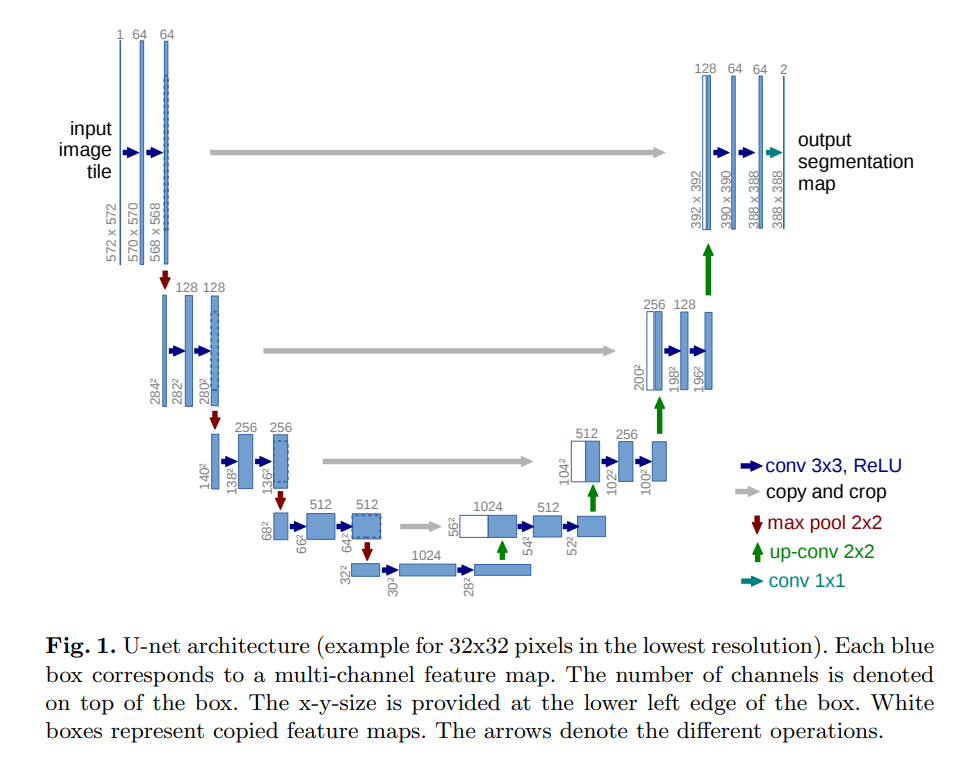
There are many ways of implementing Unet, Unet can be done based on any backbone architecture: [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), [VGGNet](https://arxiv.org/pdf/1409.1556), [ResNet](https://arxiv.org/abs/1512.03385), etc.

We will be using a trick from fast.ai and Deoldify by Jason Antic, (Deoldify), Jeremy Howard (fast.ai), and Uri Manor (Salk Institute): [using ImageNet-pretrained network for implementing Unet encoder part](https://www.fast.ai/2019/05/03/decrappify/). This saves a lot of training time compared to training from scratch. 

Your task is to implement class `UnetFromPretrained`.

Here we write some code snippets, which might help with implementation.

### How to get pretrained model from [torchvision](https://pytorch.org/docs/stable/torchvision/models.html)

To get pretrained model, pass `True` to the constructor

In [10]:
vgg13_bn = tv.models.vgg13_bn(True)
print (vgg13_bn)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

You can pick specific layers from sequential models. For example, to get indexes of layers, where downscaling is happens, try the following:

In [11]:
downscale_idxs = []
for i, l in enumerate(vgg13_bn.features):
    try:
        stride = l.stride
    except:
        stride = 1
    if type(stride) is tuple:
        stride = stride[0]
    if stride > 1:
        print (i, l)
        downscale_idxs.append(i)

6 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
13 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
20 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
27 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
34 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


 To create a block from the part of the model, you can use the following:
 

In [12]:
st_idx = 3
fin_idx = 8
module = nn.Sequential(*vgg13_bn.features[st_idx:fin_idx])
print (module)

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


We recommend to use `kornia.PyrDown()` for downscaling and `F.interpolate(***, mode='bilinear', align_corners = False)` for upscaling. For detailed reference and more advanced variants see [The Devil is in the Decoder: Classification, Regression and GANs](https://arxiv.org/abs/1707.05847).

If you use normalization in the decoder, it is safer to use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm), `nn.GroupNorm` instead of BatchNorm because of small batch size.

In [14]:
class Upscale_like(nn.Module):
    def forward(self,x, example):
        return F.interpolate(x, (example.size(2), example.size(3)), mode='bilinear', align_corners = False)

class DownscaleConv(nn.Module):
    """"""
    def __init__(self, input_features, output_features):
        super(DownscaleConv, self).__init__()
        self.in_f = input_features
        self.out_f = output_features
        self.features = nn.Sequential(
            nn.Conv2d(self.in_f, self.out_f, kernel_size=3, stride = 1, padding=1, bias = True),
            nn.LeakyReLU(0.1),
            nn.GroupNorm(8, self.out_f),
            K.geometry.PyrDown()
        )
        return
    def forward(self, input):
        x = self.features(input)
        return x

class UpscaleConv(nn.Module):
    """"""
    def __init__(self, input_to_upscale_feats, shortcut_input_feats,  output_features):
        super(UpscaleConv, self).__init__()
        self.up = Upscale_like()
        self.in_f1 = input_to_upscale_feats
        self.in_f2 = shortcut_input_feats
        self.in_f = self.in_f1 + self.in_f2
        self.out_f = output_features
        self.features = nn.Sequential(
            nn.GroupNorm(8, self.in_f),
            nn.Conv2d(self.in_f, self.out_f, kernel_size=3, stride = 1, padding=1, bias = True),
            nn.LeakyReLU(0.1),
        )
        return
    def forward(self, input_to_upscale, shortcut_input):
        x = self.features(torch.cat([self.up(input_to_upscale, shortcut_input),shortcut_input],dim=1))
        return x

In [15]:
#
class UnetFromPretrained(nn.Module):
    def __init__(self, encoder):
        super(UnetFromPretrained, self).__init__()
        downscale_idxs = []
        out_channels = []
        for i, l in enumerate(encoder):
            try:
                stride = l.stride
            except:
                stride = 1
            if type(stride) is tuple:
                stride = stride[0]
            if stride > 1:
                #print (i, l)
                downscale_idxs.append(i)
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.downscale_module = K.geometry.PyrDown()
        start_idx = 0
        for fin_idx in downscale_idxs:
            module = nn.Sequential(*encoder[start_idx:fin_idx], self.downscale_module)
            out_channels.append(module[-3].weight.shape[0])
            self.down_blocks.append(module)
            start_idx = fin_idx+1
        out_channels_rev = out_channels[::-1]
        for ch_up, ch_short in zip(out_channels_rev[:-1], out_channels_rev[1:]):
            self.up_blocks.append(UpscaleConv(ch_up, ch_short, ch_short))
        self.final = nn.Conv2d(out_channels[0], 3, kernel_size=1, stride = 1, padding=0, bias = True)
        self.final_upscale = Upscale_like()
        return
    def forward(self, input):
        downs = []
        x = input
        for db in self.down_blocks:
            x2 = db(x)
            downs.append(x2)
            x = x2
        ups = [downs[-1]]
        for i, ub in enumerate(self.up_blocks):
            ups.append(ub(ups[-1], downs[-(i+2)]))
        out = self.final(self.final_upscale(ups[-1], input)) + input
        # HIDE_IN_TEMPLATE_STOP
        return out
unet = UnetFromPretrained(vgg13_bn.features)
print (unet)

UnetFromPretrained(
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): PyrDown()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): PyrDown()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_siz

## Perceptual loss

As loss we will be using so called perceptual loss. Below is the Figure from  [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) by Justin Johnson, Alexandre Alahi, and Li Fei-Fei, ECCV 2016, where it was proposed at first.

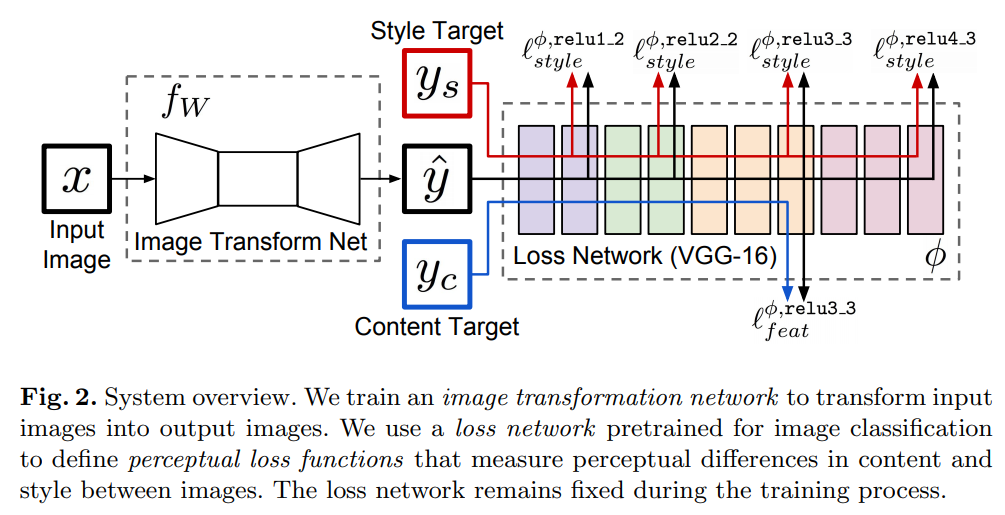


It is a simple mean square error (MSE) loss between generated image and target image, but not on the pixel level, but instead on some feature map of the ImageNet pretrained network. Compared to MSE-pixel loss it tends to produce less blurry images, compared to L1 loss - better to capture semantics and small image misalignments. 

It is also used as a first part of [NoGAN training](https://www.fast.ai/2019/05/03/decrappify/) by Deoldify by Jason Antic, (Deoldify), Jeremy Howard (fast.ai), and Uri Manor (Salk Institute). Also it was proposed in "[Learning Implicit Generative Models by Matching Perceptual Features](http://openaccess.thecvf.com/content_ICCV_2019/papers/dos_Santos_Learning_Implicit_Generative_Models_by_Matching_Perceptual_Features_ICCV_2019_paper.pdf)" by Cicero Nogueira dos Santos, Youssef Mroueh, Inkit Padhi, Pierre Dognin. which inspired the current assignment. 

We will implement `class ContentLoss(nn.Module)`, which takes pretrained architecture network name and `layer_id` and an input and creates such a network during initialization. During `forward` it should do forward pass of input image and target image through this network and calculate `F.mse_loss` between them. Hint: to save time and memory, you can use `with torch.no_grad():` for getting the features of the target (**but not the generated**) image

In [16]:
import torchvision as tv
import torch.nn.functional as F


class ContentLoss(nn.Module):
    """"""
    def __init__(self, arch = 'alexnet', layer_id = 11):
        super(ContentLoss, self).__init__()
        # HIDE_IN_TEMPLATE_START
        self.layer_id = layer_id
        if arch == 'alexnet':
            cnn = tv.models.alexnet(True)
        else:
            cnn = tv.models.vgg13_bn(True)
        self.content_cnn =  nn.Sequential(*cnn.features[:layer_id])
        self.content_cnn.eval()
        # HIDE_IN_TEMPLATE_STOP
        return
    def forward(self, input, label):
        with torch.no_grad():
            target_feats = self.content_cnn(label)
        in_feats = self.content_cnn(input)
        loss = F.mse_loss(in_feats, target_feats)
        return loss

In [17]:
model = UnetFromPretrained(tv.models.vgg13_bn(True).features)
loss_fn_content = ContentLoss('alexnet', 11)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENE

  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
learn = Learner(dls, model, loss_func=loss_fn_content)

Or, if you don't want to code, you can use `fastai` unet generator.

In [ ]:
#import timm
#from fastai.vision.models import resnet34
#
#model = timm.create_model('resnet18', pretrained=True)
#m = nn.Sequential(*list(m.children())[:-2])
#model_color = DynamicUnet(m, 3, (128,128), norm_type=None)
#
#learn = Learner(dls, model_color, loss_func=ContentLoss())

In [20]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,0.446298,0.459496,04:54
1,0.420560,0.425842,04:52


In [ ]:
learn.show_results()

In [22]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

MessageError: ignored

In [ ]:
img=PILImage(load_image('tr1.jpg'))
pred = learn.predict(img)